In [57]:
import pandas as pd
from ast import literal_eval
import operator
import numpy as np
import statsmodels as sm
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.special import rel_entr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats


%matplotlib inline

In [2]:
# clusters = pd.read_csv("../results/all_runs.csv")

In [3]:
df = pd.read_csv("../distribution.csv")
hydrated_tweets = pd.read_csv("../data/hydrated_tweets.csv")

In [4]:
df['tweetLengthWords'] = df['tweetTextList'].apply(lambda x: len(literal_eval(x)))
df['noteLengthWords'] = df['noteTextList'].apply(lambda x: len(literal_eval(x)))
df['tweetLengthChars'] = df['tweetTextList'].apply(lambda x: len(x))

In [7]:
df[['tweetLengthWords', 'noteLengthWords']].describe()
# maybe the limit should be 8 to cut out the bottom 25% 

,tweetLengthWords,noteLengthWords
count,11599.000000,11599.000000
mean,14.474006,14.656436
std,7.722712,7.712288
min,1.000000,1.000000
25%,8.000000,8.000000
50%,14.000000,15.000000
75%,21.000000,22.000000
max,44.000000,45.000000


In [8]:
# a tweet with commentary about BLM and MLK, a note refuting the tweet's take. High quality
mlk = df[df['noteId'] == 1483230774144888832]

# a tweet about dissapointment in President Biden re. Afghanistan, a note about the situation in Afghanistan # unknown quality 
afghanistan = df[df['noteId'] == 1432821040392986634]

# a tweet asking Santa for weapons, a response that Santa isn't real. Low quality / meme-y 
santa = df[df['noteId'] == 1467558037116178436]

In [9]:
ratings = pd.read_csv("../data/ratings-00000.tsv", sep = "\t")

ratings["helpfulnessLevel"] = np.where(ratings["helpfulnessLevel"].isna(),
                                       ratings['helpful'],
                                      ratings["helpfulnessLevel"])

ratings["helpfulnessLevel"] = np.where(ratings["helpfulnessLevel"] == "HELPFUL", 1,
                                      np.where(
                                      ratings["helpfulnessLevel"] == "NOT_HELPFUL", -1, 
                                      np.where(
                                      ratings["helpfulnessLevel"] == "SOMEWHAT_HELPFUL", 0,
                                      ratings["helpfulnessLevel"]))
                                      )

ratings["helpfulnessLevel"] = ratings["helpfulnessLevel"].astype(float)

ratings_grouped = ratings.groupby(["noteId"])['helpfulnessLevel'].mean().reset_index()

In [10]:
# Look at the Histograms of each document's probability distribution 

In [11]:
def probPlot(sliced_df, title):
    temp = literal_eval(sliced_df['probs_note'].values[0])
    temp2 = literal_eval(sliced_df['probs_tweet'].values[0])
    classes = list(temp.keys())
    classes = [str(x+1) for x in classes]
    p = list(temp.values())
    q = list(temp2.values())
    # maintain good social media ethics practices and don't call out specific birdwatch notes / tweets here 
    plt.suptitle(title, fontsize = 20)
    plt.subplot(2,1,1).set_title("Note", fontsize=16)
    plt.bar(classes, p)
    # plot second distribution
    plt.subplot(2,1,2).set_title("Tweet",fontsize = 16)
    plt.bar(classes, q)
    plt.xlabel("Cluster")
    # show the plot
    plt.tight_layout()
    plt.show()
    
def KL(x, order = "tn"):
    temp = literal_eval(x['probs_note'])
    temp2 = literal_eval(x['probs_tweet'])
    

    n = list(temp.values())
    t = list(temp2.values())
    
    if order == "nt":
        return sum(rel_entr(n,t))
    elif order == "tn":
        return sum(rel_entr(t,n))
    

    
    

In [75]:
test = df[df['noteId'] == 1434596883993927682]

In [83]:
test['probs_note'].values[0]

'{0: 0.00026110201862673886, 1: 0.013687334954063629, 2: 0.06411241549251506, 3: 0.059568265998614, 4: 0.07257811794168263, 5: 0.15235116433590049, 6: 0.05048801585298493, 7: 0.019790152595916603, 8: 0.016627355135905682, 9: 0.138531440458339, 10: 0.001060667213796683, 11: 0.06577204407998058, 12: 0.003988466753740058, 13: 0.0680374659764353, 14: 0.038004641493380675, 15: 0.037204286995158625, 16: 0.028774377408092622, 17: 0.027492478058813975, 18: 0.10458452804002526, 19: 0.03708567919602759}'

In [94]:
def KSUniform(test, doc="note"):
    if doc == "tweet":
        X = literal_eval(test['probs_tweet'])
    elif doc == "note":
        X = literal_eval(test['probs_note'])
    X = np.array(list(X.values()))
    return stats.kstest(X, 'uniform')[0]

In [95]:
stats.kstest(X, 'uniform')

KstestResult(statistic=0.9437806602485506, pvalue=1.9895039844995628e-25)

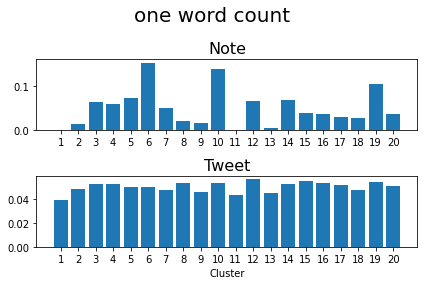

In [96]:
probPlot(test, "one word count")

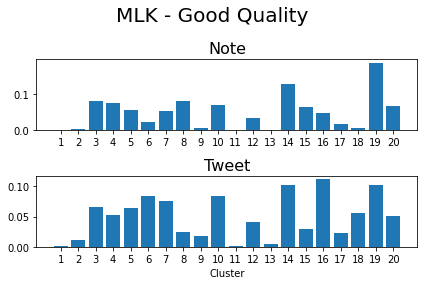

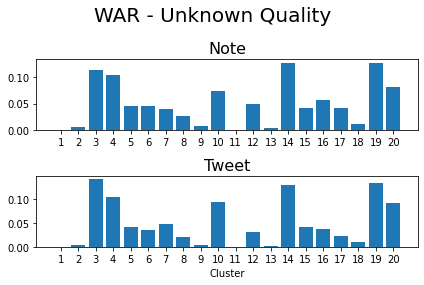

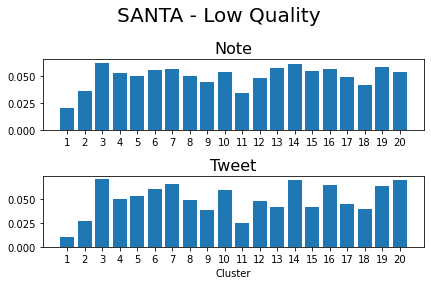

In [97]:
probPlot(mlk, "MLK - Good Quality")
probPlot(afghanistan, "WAR - Unknown Quality")
probPlot(santa, "SANTA - Low Quality")

In [98]:
test[test['noteId'] == 1467558037116178436]

,Unnamed: 0,noteTextList,noteId,tweetId,probs_note,tweetTextList,probs_tweet,_merge,tweetLengthWords,noteLengthWords,tweetLengthChars


In [99]:
merged_df = pd.merge(df, ratings_grouped, how="left", on="noteId", indicator="merge_ratings")

In [100]:
# would do ordinal regression but how would i normalize a note with multiple ratings? 

merged_df['KL_nt'] = merged_df.apply(lambda x: KL(x, "nt"), axis=1)
merged_df['KL_tn'] = merged_df.apply(lambda x: KL(x, "tn"), axis=1)


In [101]:
merged_df['KS_test_note'] = merged_df.apply(lambda x: KSUniform(x, "note"), axis = 1 )
merged_df['KS_test_tweet'] = merged_df.apply(lambda x: KSUniform(x, "tweet"), axis = 1 )

In [106]:
# test set it now the note/tweet pairs that have ratings associated with the notes 
test = merged_df[merged_df['merge_ratings'] == "both"]

<AxesSubplot:xlabel='KS_test_note', ylabel='noteLengthWords'>

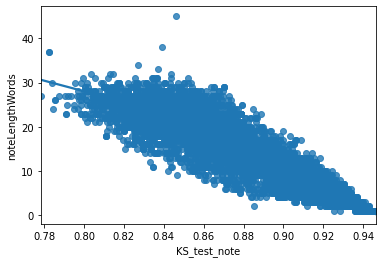

In [107]:
sns.regplot(data=merged_df, x="KS_test_note", y="noteLengthWords", lowess=True)

<AxesSubplot:xlabel='KS_test_tweet', ylabel='tweetLengthWords'>

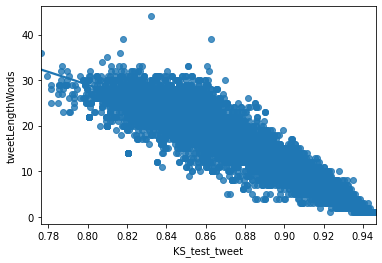

In [108]:
sns.regplot(data=merged_df, x="KS_test_tweet", y="tweetLengthWords", lowess=True)

<AxesSubplot:xlabel='noteLengthWords', ylabel='KL_tn'>

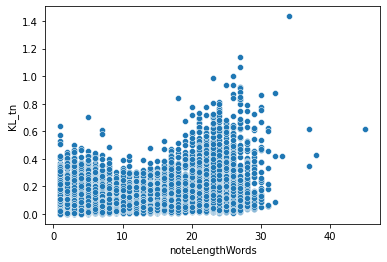

In [33]:
sns.scatterplot(data=test, x="noteLengthWords", y="KL_tn")

<AxesSubplot:xlabel='noteLengthWords', ylabel='KL_tn'>

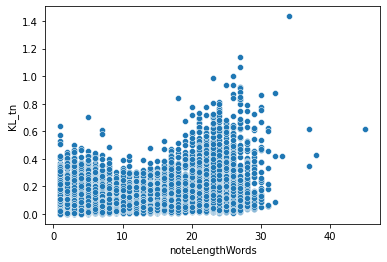

In [34]:
sns.scatterplot(data=test, x="noteLengthWords", y="KL_tn")

<AxesSubplot:xlabel='tweetLengthWords', ylabel='KL_nt'>

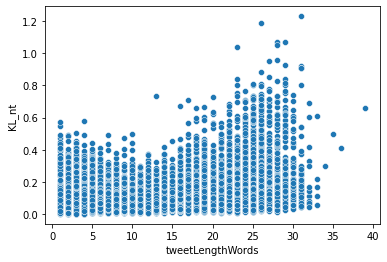

In [35]:
sns.scatterplot(data=test, x="tweetLengthWords", y="KL_nt")

<AxesSubplot:xlabel='noteLengthWords', ylabel='KL_nt'>

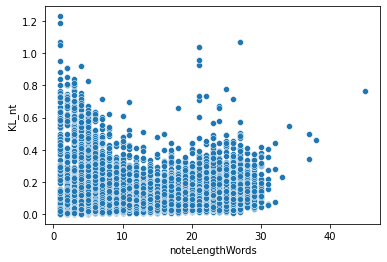

In [36]:
sns.scatterplot(data=test, x="noteLengthWords", y="KL_nt")

<AxesSubplot:xlabel='noteLengthWords', ylabel='KL_nt'>

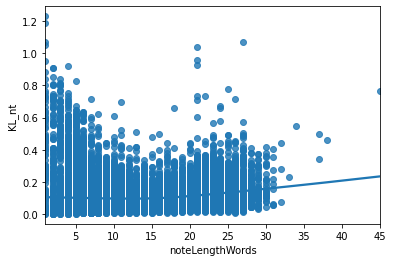

In [43]:
sns.regplot(data=test, x="noteLengthWords", y="KL_nt", lowess=True)

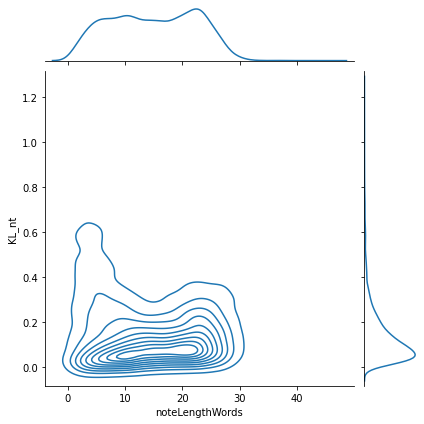

In [46]:
sns.jointplot(data=test, x="noteLengthWords", y="KL_nt", kind="kde")

In [38]:
test[test['tweetLengthWords'] == 1]

,Unnamed: 0,noteTextList,noteId,tweetId,probs_note,tweetTextList,probs_tweet,_merge,tweetLengthWords,noteLengthWords,tweetLengthChars,helpfulnessLevel,merge_ratings,KL_nt,KL_tn
51,51,"['amendment', 'clearly', 'states', 'persons', ...",1434596883993927682,1433145774381191181,"{0: 0.00026110201862673886, 1: 0.0136873349540...",['thoughts'],"{0: 0.03909422119530459, 1: 0.0484041780993395...",both,1,19,12,-1.000000,both,0.312375,0.531818
83,83,"['ghislaine', 'maxwells', 'trial', 'federal', ...",1462180342563950592,1462125901173432322,"{0: 9.436813631109612e-05, 1: 0.00858398391936...",['understand'],"{0: 0.03651939835598223, 1: 0.0444203446301711...",both,1,21,14,0.545455,both,0.300642,0.626360
91,91,"['true', 'gasoline', 'prices', 'risen', 'signi...",1459322495824281604,1456722561107103750,"{0: 5.078014854328167e-05, 1: 0.01380003193624...",['part'],"{0: 0.0357978896155778, 1: 0.04432451873731428...",both,1,23,8,1.000000,both,0.295657,0.604590
239,239,"['according', 'snopes', 'ceo', 'pfizer', 'albe...",1456730732383154179,1456614483661623296,"{0: 0.010826202211373549, 1: 0.025880390284763...",['interesting'],"{0: 0.03895870112050611, 1: 0.0440853758013976...",both,1,7,15,1.000000,both,0.046441,0.056469
729,729,"['tweet', 'misleading', 'shares', 'image', 'ac...",1434542896682733572,1433905291813261314,"{0: 0.00241236583890444, 1: 0.0169505436691997...",['bible'],"{0: 0.039002567852236124, 1: 0.046069208682597...",both,1,10,9,1.000000,both,0.137813,0.197824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11101,11101,"['clearly', 'tongue', 'cheek']",1430858966599278592,1430818638588690432,"{0: 0.019697500661254294, 1: 0.036497684894863...",['weeks'],"{0: 0.03818614375789224, 1: 0.0466133637921476...",both,1,3,9,0.764706,both,0.018887,0.019921
11224,11224,"['bidens', 'proposed', 'tax', 'plan', 'indeed'...",1445120712797196289,1445118829605097480,"{0: 5.569661293791724e-05, 1: 0.01062395278658...",['fixed'],"{0: 0.04015088103945286, 1: 0.0463530974248129...",both,1,23,9,-1.000000,both,0.348355,0.659451
11357,11357,"['satirical', 'joke', 'relatively', 'obvious',...",1431138840715034625,1430818638588690432,"{0: 0.0025063556430163975, 1: 0.02078603056523...",['weeks'],"{0: 0.03818614375789224, 1: 0.0466133637921476...",both,1,10,9,0.750000,both,0.147577,0.209156
11454,11454,"['debunked', 'usa', 'today', 'fact', 'checkers...",1379292140333903873,1379014801750437889,"{0: 0.001901656959993645, 1: 0.016912387586617...",['thinking'],"{0: 0.03748403276604413, 1: 0.0456295319454012...",both,1,10,12,1.000000,both,0.125991,0.190158


In [109]:
# does KL divergence increase as helpfulness level increases? 
# test[test['tweetLengthWords'] > 10] 

lm = smf.ols('helpfulnessLevel ~ KL_tn', test[test['tweetLengthWords'] > 8 ]  )
result = lm.fit(cov_type = 'HC0')


In [110]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       helpfulnessLevel   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     18.70
Date:                Thu, 17 Feb 2022   Prob (F-statistic):           1.56e-05
Time:                        13:45:40   Log-Likelihood:                -5585.0
No. Observations:                6189   AIC:                         1.117e+04
Df Residuals:                    6187   BIC:                         1.119e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3701      0.013     28.979      0.0

In [ ]:
sns.scatterplot(data=test, x="KL_tn", y="helpfulnessLevel")

In [ ]:
ratings[ratings['helpfulUniqueContext'] == 1]['noteId'].nunique()

In [ ]:
ratings[ratings['helpfulImportantContext'] == 1]['helpfulImportantContext']

In [ ]:
9559 + 2523

In [ ]:
ratings.noteId.nunique()